## The parameters:
min_count = int - Ignores all words with total absolute frequency lower than this - (2, 100)

window = int - The maximum distance between the current and predicted word within a sentence. E.g. window words on the left and window words on the left of our target - (2, 10)

size = int - Dimensionality of the feature vectors. - (50, 300)

sample = float - The threshold for configuring which higher-frequency words are randomly downsampled. Highly influencial. - (0, 1e-5)

alpha = float - The initial learning rate - (0.01, 0.05)

min_alpha = float - Learning rate will linearly drop to min_alpha as training progresses. To set it: alpha - (min_alpha * epochs) ~ 0.00

negative = int - If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drown. If set to 0, no negative sampling is used. - (5, 20)

workers = int - Use these many worker threads to train the model (=faster training with multicore machines)

### Example
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [1]:
import multiprocessing
cores = multiprocessing.cpu_count() # Count the number of cores in a computer
cores

4

In [2]:
from time import time
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [3]:
t = time()
import pandas as pd
import numpy as np
import nltk
print('Time to import everything: {} seconds'.format((time() - t), 2))

Time to import everything: 14.298096656799316 seconds


In [4]:
pd.set_option('display.width',1000)
pd.set_option('max_colwidth', 1000) 

In [5]:
dic = {'Text': ["Our deeds are the reasons for this #Earthquake caused May ALLAH forgive us all",
               "Forest fire near La Ronge Sask. canada100flemming putted sold",
               "Now, this is a dummy DataSet just for playing with NLP!!",
               "We are playing or played$ , I'm in1a 5 meeting"],
        'Class': [1,0,0,1]}
df = pd.DataFrame(dic)
df

,Text,Class
0,Our deeds are the reasons for this #Earthquake caused May ALLAH forgive us all,1
1,Forest fire near La Ronge Sask. canada100flemming putted sold,0
2,"Now, this is a dummy DataSet just for playing with NLP!!",0
3,"We are playing or played$ , I'm in1a 5 meeting",1


In [6]:
df['Text'][1]

'Forest fire near La Ronge Sask. canada100flemming putted sold'

In [7]:
df['Text'].apply(lambda elem : re.sub(r'([a-zA-Z0-9])' , '', elem)) #Match alpha-numeric

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0           #      
1              .   
2     ,          !!
3          $ , '   
Name: Text, dtype: object

In [8]:
df['Text'].apply(lambda elem : re.sub(r'(\w)' , '', elem)) #Match alpha-numeric

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0           #      
1              .   
2     ,          !!
3          $ , '   
Name: Text, dtype: object

In [9]:
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
stopwords.remove('no')
stopwords.remove('not')

In [10]:
import re
def  clean_text(df, text_field, new_text_field_name):
    # cleaning,lower_case
    df[new_text_field_name] = df[text_field].str.lower()
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    # remove numbers
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"\d+", " ", elem))
    #Stop words
    df[new_text_field_name] = df[new_text_field_name].apply(lambda x : ' '.join([word for word in x.split() if word not in stopwords]))

    return df
data_clean = clean_text(df, 'Text', 'Text_clean')
data_clean.head()


,Text,Class,Text_clean
0,Our deeds are the reasons for this #Earthquake caused May ALLAH forgive us all,1,deeds reasons earthquake caused may allah forgive us
1,Forest fire near La Ronge Sask. canada100flemming putted sold,0,forest fire near la ronge sask canada flemming putted sold
2,"Now, this is a dummy DataSet just for playing with NLP!!",0,dummy dataset playing nlp
3,"We are playing or played$ , I'm in1a 5 meeting",1,playing played im meeting


In [11]:
print(sorted(stopwords))

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', 'her', 'here', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in', 'into', 'is', 'isn', "isn't", 'it', "it's", 'its', 'itself', 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'nor', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she', "she's", 'should', "should've", 'shouldn', "shouldn't", 'so', 'some', 'such', 't',

In [12]:
df['Text'].apply(lambda x : ''.join(x.split(' ')))

0    Ourdeedsarethereasonsforthis#EarthquakecausedMayALLAHforgiveusall
1                ForestfirenearLaRongeSask.canada100flemmingputtedsold
2                       Now,thisisadummyDataSetjustforplayingwithNLP!!
3                                Weareplayingorplayed$,I'min1a5meeting
Name: Text, dtype: object

In [13]:
df['Text_tokens'] = df['Text_clean'].apply(lambda x : nltk.word_tokenize(x))
df

,Text,Class,Text_clean,Text_tokens
0,Our deeds are the reasons for this #Earthquake caused May ALLAH forgive us all,1,deeds reasons earthquake caused may allah forgive us,"[deeds, reasons, earthquake, caused, may, allah, forgive, us]"
1,Forest fire near La Ronge Sask. canada100flemming putted sold,0,forest fire near la ronge sask canada flemming putted sold,"[forest, fire, near, la, ronge, sask, canada, flemming, putted, sold]"
2,"Now, this is a dummy DataSet just for playing with NLP!!",0,dummy dataset playing nlp,"[dummy, dataset, playing, nlp]"
3,"We are playing or played$ , I'm in1a 5 meeting",1,playing played im meeting,"[playing, played, im, meeting]"


In [14]:
from nltk.stem import PorterStemmer
def stemming(text):
    return ( [PorterStemmer().stem(i) for i in text] )

df['Text_tokens_stem'] = df['Text_tokens'].apply(stemming)
df

,Text,Class,Text_clean,Text_tokens,Text_tokens_stem
0,Our deeds are the reasons for this #Earthquake caused May ALLAH forgive us all,1,deeds reasons earthquake caused may allah forgive us,"[deeds, reasons, earthquake, caused, may, allah, forgive, us]","[deed, reason, earthquak, caus, may, allah, forgiv, us]"
1,Forest fire near La Ronge Sask. canada100flemming putted sold,0,forest fire near la ronge sask canada flemming putted sold,"[forest, fire, near, la, ronge, sask, canada, flemming, putted, sold]","[forest, fire, near, la, rong, sask, canada, flem, put, sold]"
2,"Now, this is a dummy DataSet just for playing with NLP!!",0,dummy dataset playing nlp,"[dummy, dataset, playing, nlp]","[dummi, dataset, play, nlp]"
3,"We are playing or played$ , I'm in1a 5 meeting",1,playing played im meeting,"[playing, played, im, meeting]","[play, play, im, meet]"


In [15]:
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer as wnl
def lemmatizing(text):
    #return( ' '.join([wnl().lemmatize(i) for i in text])
    return( ([wnl().lemmatize(i , pos="v") for i in text.split()]) )
df['Text_tokens_lemma'] = df['Text_clean'].apply(lemmatizing)
df

,Text,Class,Text_clean,Text_tokens,Text_tokens_stem,Text_tokens_lemma
0,Our deeds are the reasons for this #Earthquake caused May ALLAH forgive us all,1,deeds reasons earthquake caused may allah forgive us,"[deeds, reasons, earthquake, caused, may, allah, forgive, us]","[deed, reason, earthquak, caus, may, allah, forgiv, us]","[deeds, reason, earthquake, cause, may, allah, forgive, us]"
1,Forest fire near La Ronge Sask. canada100flemming putted sold,0,forest fire near la ronge sask canada flemming putted sold,"[forest, fire, near, la, ronge, sask, canada, flemming, putted, sold]","[forest, fire, near, la, rong, sask, canada, flem, put, sold]","[forest, fire, near, la, ronge, sask, canada, flemming, putt, sell]"
2,"Now, this is a dummy DataSet just for playing with NLP!!",0,dummy dataset playing nlp,"[dummy, dataset, playing, nlp]","[dummi, dataset, play, nlp]","[dummy, dataset, play, nlp]"
3,"We are playing or played$ , I'm in1a 5 meeting",1,playing played im meeting,"[playing, played, im, meeting]","[play, play, im, meet]","[play, play, im, meet]"


In [16]:
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()
print(wnl.lemmatize('dogs'))
print(wnl.lemmatize('churches'))
print(wnl.lemmatize('aardwolves'))
print(wnl.lemmatize('abaci'))
print(wnl.lemmatize('came'))
print(wnl.lemmatize('working'))
print(wnl.lemmatize('running'))
print(wnl.lemmatize('kids'))


dog
church
aardwolf
abacus
came
working
running
kid


In [17]:
"""
file=open("Stemming and Lemmatization\data-science-wiki.txt")
my_lines_list=file.readlines()
my_lines_list
To readlines() is used to read and copy the contents in file and .read() method is aslo used to simply view the file.
"""
l1 = ['Ali' , 'Hassan' , 'Awan']
print('{0:10} {1:13} {2:10}'.format(l1[0],l1[1],l1[2]))

Ali        Hassan        Awan      


In [18]:
nltk.corpus.gutenberg.fileids()


['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

In [19]:
from nltk.stem.snowball import SnowballStemmer
englishStemmer=SnowballStemmer("english", ignore_stopwords=True)
englishStemmer.stem("having")
def snowball_stem(text):
    #return( ' '.join([wnl().lemmatize(i) for i in text])
    return( ' '.join([englishStemmer.stem(i) for i in text.split()]) )
df['snowball_stem'] = df['Text_clean'].apply(snowball_stem)
df

,Text,Class,Text_clean,Text_tokens,Text_tokens_stem,Text_tokens_lemma,snowball_stem
0,Our deeds are the reasons for this #Earthquake caused May ALLAH forgive us all,1,deeds reasons earthquake caused may allah forgive us,"[deeds, reasons, earthquake, caused, may, allah, forgive, us]","[deed, reason, earthquak, caus, may, allah, forgiv, us]","[deeds, reason, earthquake, cause, may, allah, forgive, us]",deed reason earthquak caus may allah forgiv us
1,Forest fire near La Ronge Sask. canada100flemming putted sold,0,forest fire near la ronge sask canada flemming putted sold,"[forest, fire, near, la, ronge, sask, canada, flemming, putted, sold]","[forest, fire, near, la, rong, sask, canada, flem, put, sold]","[forest, fire, near, la, ronge, sask, canada, flemming, putt, sell]",forest fire near la rong sask canada flem put sold
2,"Now, this is a dummy DataSet just for playing with NLP!!",0,dummy dataset playing nlp,"[dummy, dataset, playing, nlp]","[dummi, dataset, play, nlp]","[dummy, dataset, play, nlp]",dummi dataset play nlp
3,"We are playing or played$ , I'm in1a 5 meeting",1,playing played im meeting,"[playing, played, im, meeting]","[play, play, im, meet]","[play, play, im, meet]",play play im meet


In [20]:
import gensim
from gensim.models import Word2Vec

In [32]:
list_words = []
for i in df['Text_tokens_lemma']:
    list_words.append(i)
    
list_words

[['deeds', 'reason', 'earthquake', 'cause', 'may', 'allah', 'forgive', 'us'],
 ['forest',
  'fire',
  'near',
  'la',
  'ronge',
  'sask',
  'canada',
  'flemming',
  'putt',
  'sell'],
 ['dummy', 'dataset', 'play', 'nlp'],
 ['play', 'play', 'im', 'meet']]

In [22]:
model = Word2Vec(list_words , min_count = 1 , size = 32)

INFO - 09:15:24: collecting all words and their counts
INFO - 09:15:24: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 09:15:24: collected 24 word types from a corpus of 26 raw words and 4 sentences
INFO - 09:15:24: Loading a fresh vocabulary
INFO - 09:15:24: effective_min_count=1 retains 24 unique words (100% of original 24, drops 0)
INFO - 09:15:24: effective_min_count=1 leaves 26 word corpus (100% of original 26, drops 0)
INFO - 09:15:24: deleting the raw counts dictionary of 24 items
INFO - 09:15:24: sample=0.001 downsamples 24 most-common words
INFO - 09:15:24: downsampling leaves estimated 4 word corpus (17.7% of prior 26)
INFO - 09:15:24: estimated required memory for 24 words and 32 dimensions: 18144 bytes
INFO - 09:15:24: resetting layer weights
INFO - 09:15:24: training model with 3 workers on 24 vocabulary and 32 features, using sg=0 hs=0 sample=0.001 negative=5 window=5
INFO - 09:15:24: worker thread finished; awaiting finish of 2 more threads
INFO

In [23]:
words = model.wv.vocab
words

{'deeds': <gensim.models.keyedvectors.Vocab at 0x20f144ace80>,
 'reason': <gensim.models.keyedvectors.Vocab at 0x20f144dce50>,
 'earthquake': <gensim.models.keyedvectors.Vocab at 0x20f1f4388b0>,
 'cause': <gensim.models.keyedvectors.Vocab at 0x20f1f438e20>,
 'may': <gensim.models.keyedvectors.Vocab at 0x20f1f438880>,
 'allah': <gensim.models.keyedvectors.Vocab at 0x20f2444a730>,
 'forgive': <gensim.models.keyedvectors.Vocab at 0x20f2444a520>,
 'us': <gensim.models.keyedvectors.Vocab at 0x20f2444a640>,
 'forest': <gensim.models.keyedvectors.Vocab at 0x20f2444a760>,
 'fire': <gensim.models.keyedvectors.Vocab at 0x20f2444a5b0>,
 'near': <gensim.models.keyedvectors.Vocab at 0x20f2444a610>,
 'la': <gensim.models.keyedvectors.Vocab at 0x20f2444a7c0>,
 'ronge': <gensim.models.keyedvectors.Vocab at 0x20f2444a040>,
 'sask': <gensim.models.keyedvectors.Vocab at 0x20f2444a0a0>,
 'canada': <gensim.models.keyedvectors.Vocab at 0x20f2444a100>,
 'flemming': <gensim.models.keyedvectors.Vocab at 0x20f2

In [24]:
words['play']

In [25]:
## Getting vectors for a word
vector = model.wv['forest']
print(vector.size)
vector

32


array([-0.01021943, -0.00217725,  0.00776735, -0.00681917,  0.0012494 ,
       -0.0077975 ,  0.00777607, -0.00905837, -0.01103895, -0.01003419,
       -0.00861255,  0.01253874,  0.00433   , -0.01423948, -0.00979067,
        0.01112971,  0.00537659,  0.01266445, -0.00263076, -0.00076148,
       -0.00202214,  0.00716948,  0.01023701,  0.00550618,  0.00677035,
       -0.0122007 ,  0.00796949, -0.0074447 , -0.01050681,  0.01221122,
        0.00776356, -0.0153233 ], dtype=float32)

In [26]:
## Same as above
import warnings
warnings.filterwarnings('ignore')
model['forest']

array([-0.01021943, -0.00217725,  0.00776735, -0.00681917,  0.0012494 ,
       -0.0077975 ,  0.00777607, -0.00905837, -0.01103895, -0.01003419,
       -0.00861255,  0.01253874,  0.00433   , -0.01423948, -0.00979067,
        0.01112971,  0.00537659,  0.01266445, -0.00263076, -0.00076148,
       -0.00202214,  0.00716948,  0.01023701,  0.00550618,  0.00677035,
       -0.0122007 ,  0.00796949, -0.0074447 , -0.01050681,  0.01221122,
        0.00776356, -0.0153233 ], dtype=float32)

In [27]:
## words similarity
similar = model.wv.most_similar('earthquake')

INFO - 09:15:36: precomputing L2-norms of word weight vectors


In [28]:
similar

[('dataset', 0.12566746771335602),
 ('canada', 0.08441205322742462),
 ('nlp', 0.07293805480003357),
 ('putt', 0.042243413627147675),
 ('im', 0.025982894003391266),
 ('may', 0.01157720759510994),
 ('fire', 0.005749940872192383),
 ('deeds', 0.004304327070713043),
 ('dummy', 0.0036766529083251953),
 ('flemming', -0.008254095911979675)]

In [29]:
print(model.most_similar(positive=['earthquake']))
print()
print(model.most_similar(negative=['earthquake']))
print()
print(model.most_similar(positive=['earthquake'] , negative=['us']))

[('dataset', 0.12566746771335602), ('canada', 0.08441205322742462), ('nlp', 0.07293805480003357), ('putt', 0.042243413627147675), ('im', 0.025982894003391266), ('may', 0.01157720759510994), ('fire', 0.005749940872192383), ('deeds', 0.004304327070713043), ('dummy', 0.0036766529083251953), ('flemming', -0.008254095911979675)]

[('meet', 0.30478039383888245), ('ronge', 0.287921279668808), ('sask', 0.21181772649288177), ('play', 0.17525731027126312), ('us', 0.17251355946063995), ('la', 0.17247316241264343), ('reason', 0.14447829127311707), ('allah', 0.11280357092618942), ('cause', 0.07960949838161469), ('forest', 0.06455114483833313)]

[('flemming', 0.21504506468772888), ('dataset', 0.14621931314468384), ('putt', 0.05679042264819145), ('deeds', 0.04520660638809204), ('canada', 0.019786685705184937), ('forgive', 0.0069839805364608765), ('cause', 0.004367798566818237), ('meet', -0.032165393233299255), ('nlp', -0.07727855443954468), ('allah', -0.0873548611998558)]


In [30]:
print(model.wv.doesnt_match("deeds reasons earthquake caused may allah forgive us".split()))

print(model.similarity('earthquake', 'us'))
print(model.similarity('earthquake', 'fire'))
print(model.similarity('earthquake', 'forgive'))
print(model.similarity('earthquake', 'deeds'))


WARNING - 09:15:41: vectors for words {'reasons', 'caused'} are not present in the model, ignoring these words


earthquake
-0.17251357
0.005749896
-0.062519826
0.004304327


In [38]:
#loading the downloaded model
# We have to downlaod this 1.5GB model (no-way I'm not going to download 😂)
model = Word2Vec.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

DeprecationWarning: Deprecated. Use gensim.models.KeyedVectors.load_word2vec_format instead.

In [29]:
## Saving , loading and training on new data
#model.save("word2vec.model")
model = Word2Vec.load("word2vec.model")
##Parameters of training
##total_examples = int - Count of sentences;
##epochs = int - Number of iterations (epochs) over the corpus - [10, 20, 30]

model.train([["this", "woman" , "beat" ,"man"]], total_examples=1, epochs=1)

INFO - 22:39:29: loading Word2Vec object from word2vec.model
INFO - 22:39:29: loading wv recursively from word2vec.model.wv.* with mmap=None
INFO - 22:39:29: setting ignored attribute vectors_norm to None
INFO - 22:39:29: loading vocabulary recursively from word2vec.model.vocabulary.* with mmap=None
INFO - 22:39:29: loading trainables recursively from word2vec.model.trainables.* with mmap=None
INFO - 22:39:29: setting ignored attribute cum_table to None
INFO - 22:39:29: loaded word2vec.model
INFO - 22:39:29: training model with 3 workers on 24 vocabulary and 32 features, using sg=0 hs=0 sample=0.001 negative=5 window=5
INFO - 22:39:29: worker thread finished; awaiting finish of 2 more threads
INFO - 22:39:29: worker thread finished; awaiting finish of 1 more threads
INFO - 22:39:29: worker thread finished; awaiting finish of 0 more threads
INFO - 22:39:29: EPOCH - 1 : training on 4 raw words (0 effective words) took 0.0s, 0 effective words/s
INFO - 22:39:29: training on a 4 raw words (

(0, 4)

In [30]:
model.wv.vocab

{'deeds': <gensim.models.keyedvectors.Vocab at 0x21f7f1d5490>,
 'reason': <gensim.models.keyedvectors.Vocab at 0x21f0a250490>,
 'earthquake': <gensim.models.keyedvectors.Vocab at 0x21f0a2502e0>,
 'cause': <gensim.models.keyedvectors.Vocab at 0x21f0f2cde20>,
 'may': <gensim.models.keyedvectors.Vocab at 0x21f0f2cdbe0>,
 'allah': <gensim.models.keyedvectors.Vocab at 0x21f0f2cd850>,
 'forgive': <gensim.models.keyedvectors.Vocab at 0x21f0f2cdd90>,
 'us': <gensim.models.keyedvectors.Vocab at 0x21f0f2cdee0>,
 'forest': <gensim.models.keyedvectors.Vocab at 0x21f0f2cdfd0>,
 'fire': <gensim.models.keyedvectors.Vocab at 0x21f0f2cdc40>,
 'near': <gensim.models.keyedvectors.Vocab at 0x21f0f2cdd30>,
 'la': <gensim.models.keyedvectors.Vocab at 0x21f0f2cde50>,
 'ronge': <gensim.models.keyedvectors.Vocab at 0x21f7ee85310>,
 'sask': <gensim.models.keyedvectors.Vocab at 0x21f0f2d0610>,
 'canada': <gensim.models.keyedvectors.Vocab at 0x21f0f2d0850>,
 'flemming': <gensim.models.keyedvectors.Vocab at 0x21f0

In [23]:
model.wv['woman']

KeyError: "word 'woman' not in vocabulary"

## Storing just words and thier tranned embedding

In [24]:
from gensim.models import KeyedVectors
word_vectors = model.wv
word_vectors.save("word2vec.wordvectors")
# Load back with memory-mapping = read-only, shared across processes.
wv = KeyedVectors.load("word2vec.wordvectors", mmap='r')
vector = wv['earthquake']
vector

array([ 5.31197572e-03,  5.60992910e-03, -1.53754547e-03, -9.63534974e-03,
       -3.69722163e-03,  4.07407759e-03,  1.27265314e-02, -1.26016606e-02,
        3.60285667e-05, -1.54112456e-02,  1.36511195e-02, -8.79176985e-03,
        6.88094506e-03, -1.05471127e-02,  4.25998494e-03,  5.00337966e-03,
        1.25492725e-03, -8.54372140e-03, -4.84031299e-03,  1.14854285e-02,
        1.08906543e-02, -6.10839343e-03,  1.28828213e-02,  8.14270880e-03,
       -6.21333951e-04,  1.30769685e-02, -6.55609043e-03,  5.47078764e-03,
       -1.06588025e-02,  1.46703757e-02, -4.66410536e-03, -5.46782138e-03],
      dtype=float32)

In [33]:
## our model is taking 18144 bytes of memory total
print(model.estimate_memory(vocab_size=24))
print(model.predict_output_word(['deeds', 'reason', 'earthquake'], topn=2))
print(model)

INFO - 18:53:43: estimated required memory for 24 words and 32 dimensions: 18144 bytes


{'vocab': 12000, 'vectors': 3072, 'syn1neg': 3072, 'total': 18144}
[('may', 0.04166706), ('us', 0.041667007)]
Word2Vec(vocab=24, size=32, alpha=0.025)


## Bigrams , checking overall vocabulary

In [33]:
from gensim.models.phrases import Phrases, Phraser

In [34]:
phrases = Phrases(list_words, min_count=1, progress_per=10000)
phrases

INFO - 09:17:51: collecting all words and their counts
INFO - 09:17:51: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 09:17:51: collected 46 word types from a corpus of 26 words (unigram + bigrams) and 4 sentences
INFO - 09:17:51: using 46 counts as vocab in Phrases<0 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>


In [35]:
tranfomred = phrases[list_words]
tranfomred

In [36]:
bigram = Phraser(phrases)
bigram

INFO - 09:17:55: source_vocab length 46
INFO - 09:17:55: Phraser built with 0 phrasegrams


In [37]:
sentences = bigram[list_words]
print(type(sentences))
sentences


<class 'gensim.interfaces.TransformedCorpus'>


In [38]:
from collections import defaultdict
dic = defaultdict(int)
for i in sentences:
    for j in i:
        dic[j]+=1
print(len(dic))
dic

24


defaultdict(int,
            {'deeds': 1,
             'reason': 1,
             'earthquake': 1,
             'cause': 1,
             'may': 1,
             'allah': 1,
             'forgive': 1,
             'us': 1,
             'forest': 1,
             'fire': 1,
             'near': 1,
             'la': 1,
             'ronge': 1,
             'sask': 1,
             'canada': 1,
             'flemming': 1,
             'putt': 1,
             'sell': 1,
             'dummy': 1,
             'dataset': 1,
             'play': 3,
             'nlp': 1,
             'im': 1,
             'meet': 1})

In [39]:
print(sorted(dic , key=dic.get , reverse=True))
dic.get('play')

['play', 'deeds', 'reason', 'earthquake', 'cause', 'may', 'allah', 'forgive', 'us', 'forest', 'fire', 'near', 'la', 'ronge', 'sask', 'canada', 'flemming', 'putt', 'sell', 'dummy', 'dataset', 'nlp', 'im', 'meet']


3

In [32]:
w2v_model = Word2Vec(min_count=1,
                     window=5,
                     size=300, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=1,
                     workers=cores-1)
model_2 = w2v_model.build_vocab(sentences, progress_per=10000)
print(model_2)
#print(model)

INFO - 22:54:06: collecting all words and their counts
INFO - 22:54:06: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 22:54:06: collected 24 word types from a corpus of 26 raw words and 4 sentences
INFO - 22:54:06: Loading a fresh vocabulary
INFO - 22:54:06: effective_min_count=1 retains 24 unique words (100% of original 24, drops 0)
INFO - 22:54:06: effective_min_count=1 leaves 26 word corpus (100% of original 26, drops 0)
INFO - 22:54:06: deleting the raw counts dictionary of 24 items
INFO - 22:54:06: sample=0.001 downsamples 24 most-common words
INFO - 22:54:06: downsampling leaves estimated 4 word corpus (17.7% of prior 26)
INFO - 22:54:06: estimated required memory for 24 words and 300 dimensions: 69600 bytes
INFO - 22:54:06: resetting layer weights


None


In [33]:
print(w2v_model.corpus_count)
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 22:54:08: training model with 3 workers on 24 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=1 window=5
INFO - 22:54:08: worker thread finished; awaiting finish of 2 more threads
INFO - 22:54:08: worker thread finished; awaiting finish of 1 more threads
INFO - 22:54:08: worker thread finished; awaiting finish of 0 more threads
INFO - 22:54:08: EPOCH - 1 : training on 26 raw words (4 effective words) took 0.0s, 714 effective words/s
INFO - 22:54:08: worker thread finished; awaiting finish of 2 more threads
INFO - 22:54:08: worker thread finished; awaiting finish of 1 more threads
INFO - 22:54:08: worker thread finished; awaiting finish of 0 more threads
INFO - 22:54:08: EPOCH - 2 : training on 26 raw words (5 effective words) took 0.0s, 1089 effective words/s
INFO - 22:54:08: worker thread finished; awaiting finish of 2 more threads
INFO - 22:54:08: worker thread finished; awaiting finish of 1 more threads
INFO - 22:54:08: worker thread finished; awaiting fini

4


INFO - 22:54:08: worker thread finished; awaiting finish of 1 more threads
INFO - 22:54:08: worker thread finished; awaiting finish of 0 more threads
INFO - 22:54:08: EPOCH - 15 : training on 26 raw words (6 effective words) took 0.0s, 1374 effective words/s
INFO - 22:54:08: worker thread finished; awaiting finish of 2 more threads
INFO - 22:54:08: worker thread finished; awaiting finish of 1 more threads
INFO - 22:54:08: worker thread finished; awaiting finish of 0 more threads
INFO - 22:54:08: EPOCH - 16 : training on 26 raw words (3 effective words) took 0.0s, 690 effective words/s
INFO - 22:54:08: worker thread finished; awaiting finish of 2 more threads
INFO - 22:54:08: worker thread finished; awaiting finish of 1 more threads
INFO - 22:54:08: worker thread finished; awaiting finish of 0 more threads
INFO - 22:54:08: EPOCH - 17 : training on 26 raw words (5 effective words) took 0.0s, 660 effective words/s
INFO - 22:54:08: worker thread finished; awaiting finish of 2 more threads


Time to train the model: 0.01 mins


In [34]:
##As we do not plan to train the model any further, we are calling init_sims(), which will make the model much more memory-efficient:
w2v_model.init_sims(replace=True)

INFO - 22:54:10: precomputing L2-norms of word weight vectors


### Incrementsl training

In [40]:
w2v_model = Word2Vec(min_count=1,
                     window=5,
                     size=300, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=1,
                     workers=cores-1)
print(list_words)

[['deeds', 'reason', 'earthquake', 'cause', 'may', 'allah', 'forgive', 'us'], ['forest', 'fire', 'near', 'la', 'ronge', 'sask', 'canada', 'flemming', 'putt', 'sell'], ['dummy', 'dataset', 'play', 'nlp'], ['play', 'play', 'im', 'meet']]


In [42]:
model_3 = w2v_model.build_vocab(list_words[0:3], progress_per=10000)
print(model_3)


INFO - 09:21:44: collecting all words and their counts
INFO - 09:21:44: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 09:21:44: collected 22 word types from a corpus of 22 raw words and 3 sentences
INFO - 09:21:44: Loading a fresh vocabulary
INFO - 09:21:44: effective_min_count=1 retains 22 unique words (100% of original 22, drops 0)
INFO - 09:21:44: effective_min_count=1 leaves 22 word corpus (100% of original 22, drops 0)
INFO - 09:21:44: deleting the raw counts dictionary of 22 items
INFO - 09:21:44: sample=0.001 downsamples 22 most-common words
INFO - 09:21:44: downsampling leaves estimated 3 word corpus (17.0% of prior 22)
INFO - 09:21:44: estimated required memory for 22 words and 300 dimensions: 63800 bytes
INFO - 09:21:44: resetting layer weights


None


In [44]:
print(w2v_model.corpus_count)

3


In [45]:
w2v_model.train(list_words[0:3], total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

INFO - 09:25:05: training model with 3 workers on 22 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=1 window=5
INFO - 09:25:05: worker thread finished; awaiting finish of 2 more threads
INFO - 09:25:05: worker thread finished; awaiting finish of 1 more threads
INFO - 09:25:05: worker thread finished; awaiting finish of 0 more threads
INFO - 09:25:05: EPOCH - 1 : training on 22 raw words (3 effective words) took 0.0s, 658 effective words/s
INFO - 09:25:05: worker thread finished; awaiting finish of 2 more threads
INFO - 09:25:05: worker thread finished; awaiting finish of 1 more threads
INFO - 09:25:05: worker thread finished; awaiting finish of 0 more threads
INFO - 09:25:05: EPOCH - 2 : training on 22 raw words (3 effective words) took 0.0s, 613 effective words/s
INFO - 09:25:05: worker thread finished; awaiting finish of 2 more threads
INFO - 09:25:05: worker thread finished; awaiting finish of 1 more threads
INFO - 09:25:05: worker thread finished; awaiting finis

INFO - 09:25:05: worker thread finished; awaiting finish of 1 more threads
INFO - 09:25:05: worker thread finished; awaiting finish of 0 more threads
INFO - 09:25:05: EPOCH - 25 : training on 22 raw words (3 effective words) took 0.0s, 590 effective words/s
INFO - 09:25:05: worker thread finished; awaiting finish of 2 more threads
INFO - 09:25:05: worker thread finished; awaiting finish of 1 more threads
INFO - 09:25:05: worker thread finished; awaiting finish of 0 more threads
INFO - 09:25:05: EPOCH - 26 : training on 22 raw words (3 effective words) took 0.0s, 651 effective words/s
INFO - 09:25:05: worker thread finished; awaiting finish of 2 more threads
INFO - 09:25:05: worker thread finished; awaiting finish of 1 more threads
INFO - 09:25:05: worker thread finished; awaiting finish of 0 more threads
INFO - 09:25:05: EPOCH - 27 : training on 22 raw words (6 effective words) took 0.0s, 1336 effective words/s
INFO - 09:25:05: worker thread finished; awaiting finish of 2 more threads


(109, 660)

In [47]:
w2v_model.wv.vocab

{'deeds': <gensim.models.keyedvectors.Vocab at 0x20f25e2a310>,
 'reason': <gensim.models.keyedvectors.Vocab at 0x20f25e2ae20>,
 'earthquake': <gensim.models.keyedvectors.Vocab at 0x20f25e2a130>,
 'cause': <gensim.models.keyedvectors.Vocab at 0x20f25e2ac40>,
 'may': <gensim.models.keyedvectors.Vocab at 0x20f26003550>,
 'allah': <gensim.models.keyedvectors.Vocab at 0x20f260033a0>,
 'forgive': <gensim.models.keyedvectors.Vocab at 0x20f26003310>,
 'us': <gensim.models.keyedvectors.Vocab at 0x20f26003430>,
 'forest': <gensim.models.keyedvectors.Vocab at 0x20f25b49f70>,
 'fire': <gensim.models.keyedvectors.Vocab at 0x20f25b49a90>,
 'near': <gensim.models.keyedvectors.Vocab at 0x20f25b49940>,
 'la': <gensim.models.keyedvectors.Vocab at 0x20f25b49b20>,
 'ronge': <gensim.models.keyedvectors.Vocab at 0x20f25b498e0>,
 'sask': <gensim.models.keyedvectors.Vocab at 0x20f25b49f40>,
 'canada': <gensim.models.keyedvectors.Vocab at 0x20f25dd9df0>,
 'flemming': <gensim.models.keyedvectors.Vocab at 0x20f2

In [53]:
list_words[3:]

[['play', 'play', 'im', 'meet']]

In [54]:
w2v_model.build_vocab(list_words[3:], progress_per=10000 , update = True)

INFO - 09:29:24: collecting all words and their counts
INFO - 09:29:24: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 09:29:24: collected 3 word types from a corpus of 4 raw words and 1 sentences
INFO - 09:29:24: Updating model with new vocabulary
INFO - 09:29:24: New added 3 unique words (50% of original 6) and increased the count of 3 pre-existing words (50% of original 6)
INFO - 09:29:24: deleting the raw counts dictionary of 3 items
INFO - 09:29:24: sample=0.001 downsamples 6 most-common words
INFO - 09:29:24: downsampling leaves estimated 0 word corpus (11.4% of prior 4)
INFO - 09:29:24: estimated required memory for 6 words and 300 dimensions: 17400 bytes
INFO - 09:29:24: updating layer weights


In [55]:
w2v_model.train(list_words[4:], total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

INFO - 09:29:27: training model with 3 workers on 24 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=1 window=5
INFO - 09:29:27: worker thread finished; awaiting finish of 2 more threads
INFO - 09:29:27: worker thread finished; awaiting finish of 1 more threads
INFO - 09:29:27: worker thread finished; awaiting finish of 0 more threads
INFO - 09:29:27: EPOCH - 1 : training on 0 raw words (0 effective words) took 0.0s, 0 effective words/s
WARNING - 09:29:27: EPOCH - 1 : supplied example count (0) did not equal expected count (1)
INFO - 09:29:27: worker thread finished; awaiting finish of 2 more threads
INFO - 09:29:27: worker thread finished; awaiting finish of 1 more threads
INFO - 09:29:27: worker thread finished; awaiting finish of 0 more threads
INFO - 09:29:27: EPOCH - 2 : training on 0 raw words (0 effective words) took 0.0s, 0 effective words/s
WARNING - 09:29:27: EPOCH - 2 : supplied example count (0) did not equal expected count (1)
INFO - 09:29:27: worker thr

INFO - 09:29:27: worker thread finished; awaiting finish of 1 more threads
INFO - 09:29:27: worker thread finished; awaiting finish of 0 more threads
INFO - 09:29:27: EPOCH - 20 : training on 0 raw words (0 effective words) took 0.0s, 0 effective words/s
WARNING - 09:29:27: EPOCH - 20 : supplied example count (0) did not equal expected count (1)
INFO - 09:29:27: worker thread finished; awaiting finish of 2 more threads
INFO - 09:29:27: worker thread finished; awaiting finish of 1 more threads
INFO - 09:29:27: worker thread finished; awaiting finish of 0 more threads
INFO - 09:29:27: EPOCH - 21 : training on 0 raw words (0 effective words) took 0.0s, 0 effective words/s
WARNING - 09:29:27: EPOCH - 21 : supplied example count (0) did not equal expected count (1)
INFO - 09:29:27: worker thread finished; awaiting finish of 2 more threads
INFO - 09:29:27: worker thread finished; awaiting finish of 1 more threads
INFO - 09:29:27: worker thread finished; awaiting finish of 0 more threads
INFO

(0, 0)

In [56]:
w2v_model.wv.vocab

{'deeds': <gensim.models.keyedvectors.Vocab at 0x20f25e2a310>,
 'reason': <gensim.models.keyedvectors.Vocab at 0x20f25e2ae20>,
 'earthquake': <gensim.models.keyedvectors.Vocab at 0x20f25e2a130>,
 'cause': <gensim.models.keyedvectors.Vocab at 0x20f25e2ac40>,
 'may': <gensim.models.keyedvectors.Vocab at 0x20f26003550>,
 'allah': <gensim.models.keyedvectors.Vocab at 0x20f260033a0>,
 'forgive': <gensim.models.keyedvectors.Vocab at 0x20f26003310>,
 'us': <gensim.models.keyedvectors.Vocab at 0x20f26003430>,
 'forest': <gensim.models.keyedvectors.Vocab at 0x20f25b49f70>,
 'fire': <gensim.models.keyedvectors.Vocab at 0x20f25b49a90>,
 'near': <gensim.models.keyedvectors.Vocab at 0x20f25b49940>,
 'la': <gensim.models.keyedvectors.Vocab at 0x20f25b49b20>,
 'ronge': <gensim.models.keyedvectors.Vocab at 0x20f25b498e0>,
 'sask': <gensim.models.keyedvectors.Vocab at 0x20f25b49f40>,
 'canada': <gensim.models.keyedvectors.Vocab at 0x20f25dd9df0>,
 'flemming': <gensim.models.keyedvectors.Vocab at 0x20f2

## Visualizing

In [44]:
## We will be using PCA to make it lower dimension as the dimensions/vectors are of size 32 that a human can't interpret 
## So a 2-D diagram will be created instead of 32-D

In [42]:
from sklearn.decomposition import PCA
from matplotlib import pyplot

In [46]:
X = model[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)

In [47]:
X

array([[-1.27096213e-02, -1.45203080e-02,  1.03893140e-02,
        -1.03050740e-02,  1.30353244e-02, -1.29489647e-02,
         1.95356016e-03,  4.57123015e-03, -4.42541158e-03,
        -1.40878158e-02,  9.90195200e-03, -2.26911600e-03,
         1.50800189e-02, -1.33944172e-02,  8.90132599e-03,
         1.18251955e-02, -7.88727589e-03,  1.29776411e-02,
        -3.79221351e-03,  1.09878434e-02, -4.72463388e-03,
         7.87090510e-03, -1.46176131e-03, -1.50220748e-02,
        -9.41028167e-03, -1.51115591e-02, -6.19573565e-03,
        -5.17563545e-04, -6.78287446e-03, -4.56220470e-03,
        -1.97955826e-03, -2.84957979e-03],
       [-9.14749317e-03,  1.43449754e-02, -5.18519292e-03,
         1.03125572e-02, -8.70836884e-05,  5.00265416e-03,
        -1.07184341e-02, -9.61073954e-03, -8.80606659e-03,
        -7.30512477e-03,  3.76327452e-03, -3.80885496e-04,
        -2.23421748e-03,  3.02738114e-03,  1.26110716e-02,
        -6.98383339e-03,  1.74542563e-03,  3.40381195e-03,
        -1.07

In [48]:
words = list(model.wv.vocab)
words

['deeds',
 'reason',
 'earthquake',
 'cause',
 'may',
 'allah',
 'forgive',
 'us',
 'forest',
 'fire',
 'near',
 'la',
 'ronge',
 'sask',
 'canada',
 'flemming',
 'putt',
 'sell',
 'dummy',
 'dataset',
 'play',
 'nlp',
 'im',
 'meet']

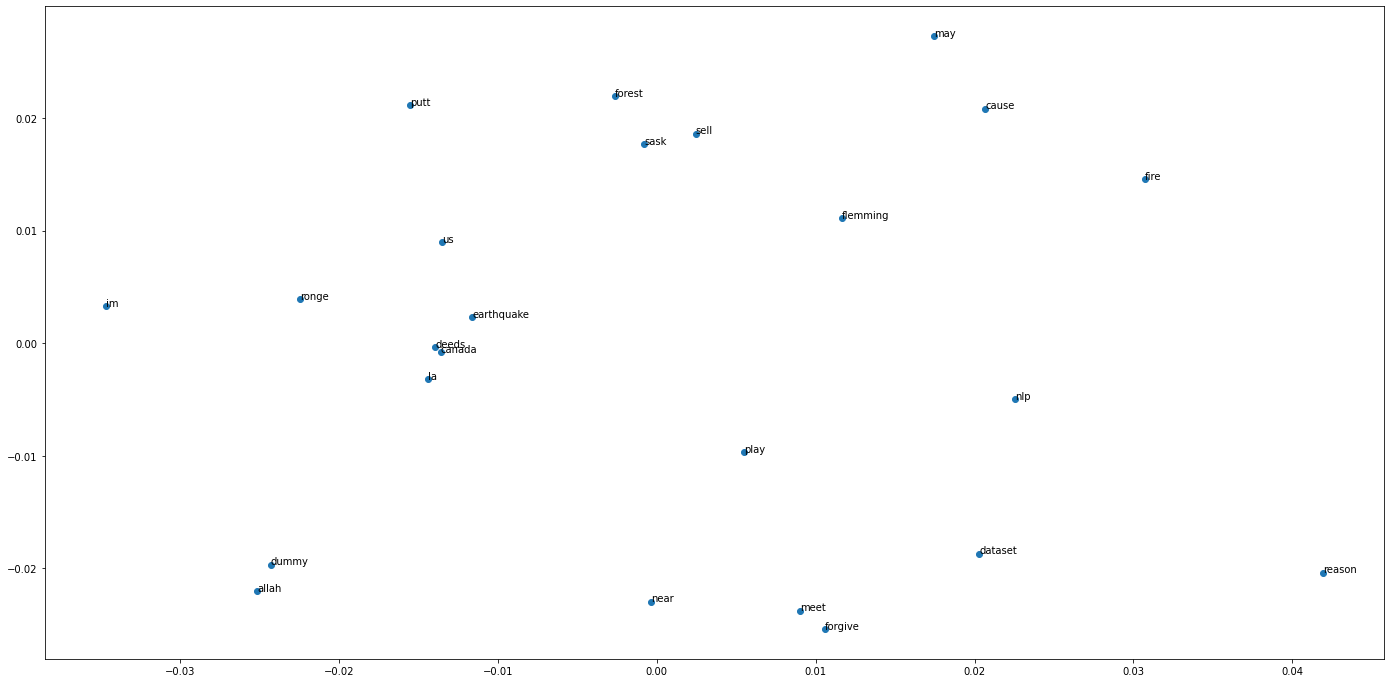

In [49]:
pyplot.figure(figsize=(24,12))
pyplot.scatter(result[:, 0], result[:, 1])
words = list(model.wv.vocab)
for i ,word in enumerate(words):
    pyplot.annotate(word , xy = (result[i,0] , result[i,1]))
pyplot.show()

In [50]:
for i , word in enumerate(words):
    print(i , word)

0 deeds
1 reason
2 earthquake
3 cause
4 may
5 allah
6 forgive
7 us
8 forest
9 fire
10 near
11 la
12 ronge
13 sask
14 canada
15 flemming
16 putt
17 sell
18 dummy
19 dataset
20 play
21 nlp
22 im
23 meet


In [51]:
result[1,0]

0.041935373

In [52]:
result[:,0]

array([-0.01392777,  0.04193537, -0.01161668,  0.02068563,  0.01747653,
       -0.02513615,  0.01058559, -0.01349717, -0.00264244,  0.03073662,
       -0.00033774, -0.01442902, -0.02243658, -0.0007773 , -0.01359646,
        0.01167357, -0.01555089,  0.00246051, -0.02430964,  0.02029121,
        0.00550617,  0.02257333, -0.03469124,  0.00902448], dtype=float32)

In [47]:
print(model.most_similar(positive=['earthquake']))

INFO - 22:48:47: precomputing L2-norms of word weight vectors


[('sask', 0.34584879875183105), ('us', 0.34541216492652893), ('canada', 0.31283333897590637), ('dummy', 0.19923855364322662), ('sell', 0.16688162088394165), ('ronge', 0.16687613725662231), ('meet', 0.1219409704208374), ('forest', 0.08370810002088547), ('deeds', 0.06412611901760101), ('la', 0.060758210718631744)]


# T-SNE visualization

In [63]:

input_word = ' earthquake, fire'
user_input = [x.strip() for x in input_word.split(',')]
print(user_input)

result_word = []
for words in user_input:
    
        sim_words = model.most_similar(words, topn = 5)
        print(sim_words)
print(len(sim_words))
print(sim_words[0])
similar_words_list = list(sim_words[0])
similar_words_list.append(words)
similar_words_list = tuple(similar_words_list)
similar_words_list

['earthquake', 'fire']
[('sask', 0.34584879875183105), ('us', 0.34541216492652893), ('canada', 0.31283333897590637), ('dummy', 0.19923855364322662), ('sell', 0.16688162088394165)]
[('may', 0.3994463384151459), ('reason', 0.25372132658958435), ('flemming', 0.1871686428785324), ('cause', 0.12604491412639618), ('play', 0.10489675402641296)]
5
('may', 0.3994463384151459)


('may', 0.3994463384151459, 'fire')

In [78]:
def append_list(sim_words, words):
    """ A list of tuples is given contaning the similar words and thier respective main word"""
    list_of_words = []
    
    for i in range(len(sim_words)):
        
        sim_words_list = list(sim_words[i])
        sim_words_list.append(words)
        sim_words_tuple = tuple(sim_words_list)
        list_of_words.append(sim_words_tuple)
        
    return list_of_words

input_word = ' earthquake'
user_input = [x.strip() for x in input_word.split(',')]
result_word = []
    
for words in user_input:
    
        sim_words = model.most_similar(words, topn = 5)
        sim_words = append_list(sim_words, words)
            
        result_word.extend(sim_words)
result_word

[('sask', 0.34584879875183105, 'earthquake'),
 ('us', 0.34541216492652893, 'earthquake'),
 ('canada', 0.31283333897590637, 'earthquake'),
 ('dummy', 0.19923855364322662, 'earthquake'),
 ('sell', 0.16688162088394165, 'earthquake')]

In [80]:
similar_word = [word[0] for word in result_word]
similarity = [word[1] for word in result_word]
similar_word.extend(user_input)
similar_word

['sask', 'us', 'canada', 'dummy', 'sell', 'earthquake']

In [81]:
labels = [word[2] for word in result_word]
label_dict = dict([(y,x+1) for x,y in enumerate(set(labels))])
print(label_dict)
color_map = [label_dict[x] for x in labels]
color_map

{'earthquake': 1}


[1, 1, 1, 1, 1]

In [85]:
model.wv.vocab.keys()

dict_keys(['deeds', 'reason', 'earthquake', 'cause', 'may', 'allah', 'forgive', 'us', 'forest', 'fire', 'near', 'la', 'ronge', 'sask', 'canada', 'flemming', 'putt', 'sell', 'dummy', 'dataset', 'play', 'nlp', 'im', 'meet'])

# Specific T-SNE

In [46]:
arrays = np.empty((0, 300), dtype='f')
word_labels = ['earthquake']
color_list  = ['red']
print(arrays.shape)

# Get vectors of the word and append it to the end f array
arrays = np.append(arrays,    w2v_model.wv.__getitem__(['earthquake']), axis=0) 
print(arrays.shape)

#gets list of most similar words
close_words = w2v_model.wv.most_similar(['earthquake'] , topn=3)
print(close_words)

# adds the vector for each of the closest words to the array
for wrd_score in close_words:
    wrd_vector = w2v_model.wv.__getitem__([wrd_score[0]])
    word_labels.append(wrd_score[0])
    color_list.append('blue')
    arrays = np.append(arrays, wrd_vector, axis=0)
print(arrays.shape) 

list_names = ['may','reason','play','cause']
# adds the vector for each of the words from list_names to the array
for wrd in list_names:
    wrd_vector = w2v_model.wv.__getitem__([wrd])
    word_labels.append(wrd)
    color_list.append('green')
    arrays = np.append(arrays, wrd_vector, axis=0)
print(arrays.shape)

# Reduces the dimensionality from 300 to 50 dimensions with PCA
reduce = PCA(n_components=8).fit_transform(arrays)
# T-SNE coordinates
Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduce)
Y

(0, 300)
(1, 300)
[('sell', 0.09566894173622131), ('us', 0.07280372083187103), ('meet', 0.05365343019366264)]
(4, 300)
(8, 300)


<IPython.core.display.Javascript object>

array([[-108.95825  , -208.94148  ],
       [ 186.48706  ,  -98.10325  ],
       [  19.245832 ,  160.85878  ],
       [ 170.65883  ,   75.445076 ],
       [  -1.3864107,  -35.04374  ],
       [-145.8001   ,  106.94461  ],
       [  64.83454  , -221.82527  ],
       [-196.90604  ,  -58.990913 ]], dtype=float32)

In [47]:
# Sets everything up to plot
print(Y.shape)
df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                    'y': [y for y in Y[:, 1]],
                    'words': word_labels,
                    'color': color_list})
print(df.shape)
df #Now we'll plot all these co-ordinates

(8, 2)
(8, 4)


,x,y,words,color
0,-108.958252,-208.941483,earthquake,red
1,186.487061,-98.103249,sell,blue
2,19.245832,160.858780,us,blue
3,170.658829,75.445076,meet,blue
4,-1.386411,-35.043739,may,green
5,-145.800095,106.944611,reason,green
6,64.834541,-221.825272,play,green
7,-196.906036,-58.990913,cause,green


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 't-SNE visualization for Earthquake')

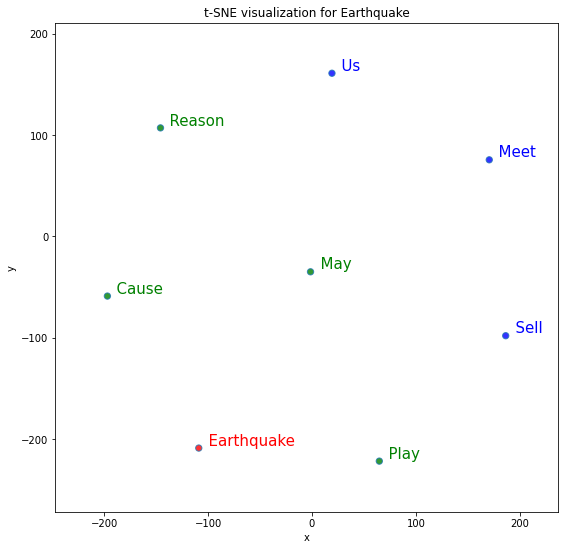

In [61]:
word = 'earthquake'
import seaborn as sns
fig, _ = plt.subplots()
fig.set_size_inches(9, 9)
p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )

# Adds annotations one by one with a loop
for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)
            
plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
plt.title('t-SNE visualization for {}'.format(word.title()))

In [67]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word],topn=3)
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=8).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))
    

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

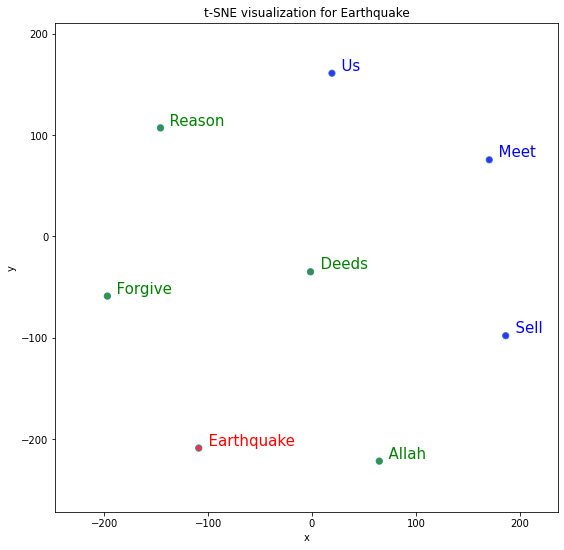

In [68]:
tsnescatterplot(w2v_model, 'earthquake', ['deeds', 'reason', 'allah', 'forgive'])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

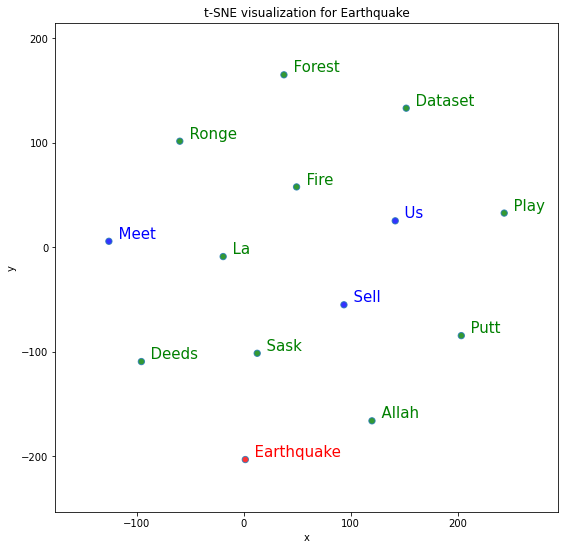

In [69]:
tsnescatterplot(w2v_model, 'earthquake', [i[0] for i in w2v_model.wv.most_similar(negative=["earthquake"])])